# Regresyon Problemlerine Giriş

Bu dersin sonunda şunları yapabiliyor olmayı hedefliyoruz:

1. Öğrendiğimiz görselleştirme yöntemlerini kullanarak veri setimiz hakkında daha detaylı bilgi edinmek
2. Değişkenler arasında görülen **korelasyon** ve **multicollinearity** kavramlarının ne anlama geldiğini kavramak
3. **Lineer Regresyon** modellerinin nasıl çalıştığını daha iyi kavramak
4. **R2** gibi regresyon analizine ilişkin değerleri nasıl yorulamamız gerektiğini kavramak
5. Model doğruluğunu arttırmak için veri seti üzerinde basit düzeyde **feature engineering** ve **değişken seçme** işlemleri gerçekleştirmek

## Veri Setleri

Bu notebook içerisinde birden fazla farklı veri setiyle çalışacağız.
1. Simple Survey Dataset
2. Car Price Predictor Dataset

## Kütüphane Yükleme

Eğer gerekliyse, bu notebook'da kullanılan kütüphaneleri `pip` komutunu kullanarak yüklememiz gerekiyor.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Simple Survey Dataset

In [2]:
df = pd.read_table('https://stats.idre.ucla.edu/wp-content/uploads/2016/02/p054.txt')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       30 non-null     int64
 1   X1      30 non-null     int64
 2   X2      30 non-null     int64
 3   X3      30 non-null     int64
 4   X4      30 non-null     int64
 5   X5      30 non-null     int64
 6   X6      30 non-null     int64
dtypes: int64(7)
memory usage: 1.8 KB


In [3]:
df.head()

,Y,X1,X2,X3,X4,X5,X6
0,43,51,30,39,61,92,45
1,63,64,51,54,63,73,47
2,71,70,68,69,76,86,48
3,61,63,45,47,54,84,35
4,81,78,56,66,71,83,47


Eğer sütun isimlerini kontrol edersek, sütun isimlerimizde boşluklar olduğunu görürüz. Ama biz neyse ki bu problemle baş etmeyi öğrendik :)

In [4]:
df.columns

Index(['Y ', 'X1 ', 'X2 ', 'X3 ', 'X4 ', 'X5 ', 'X6 '], dtype='object')

In [5]:
df.columns = df.columns.str.strip()
df.columns

Index(['Y', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6'], dtype='object')

## Görsel Çıktıları Yorumlama

Veri setimiz, toplamda **7 sütundan (6 feature, 1 target)** ve 30 satırdan oluştuğunu görüyoruz. Farklı değişkenler arasındaki ilişkileri incelemek için hesaplanan korelasyon değerlerine bakalım.

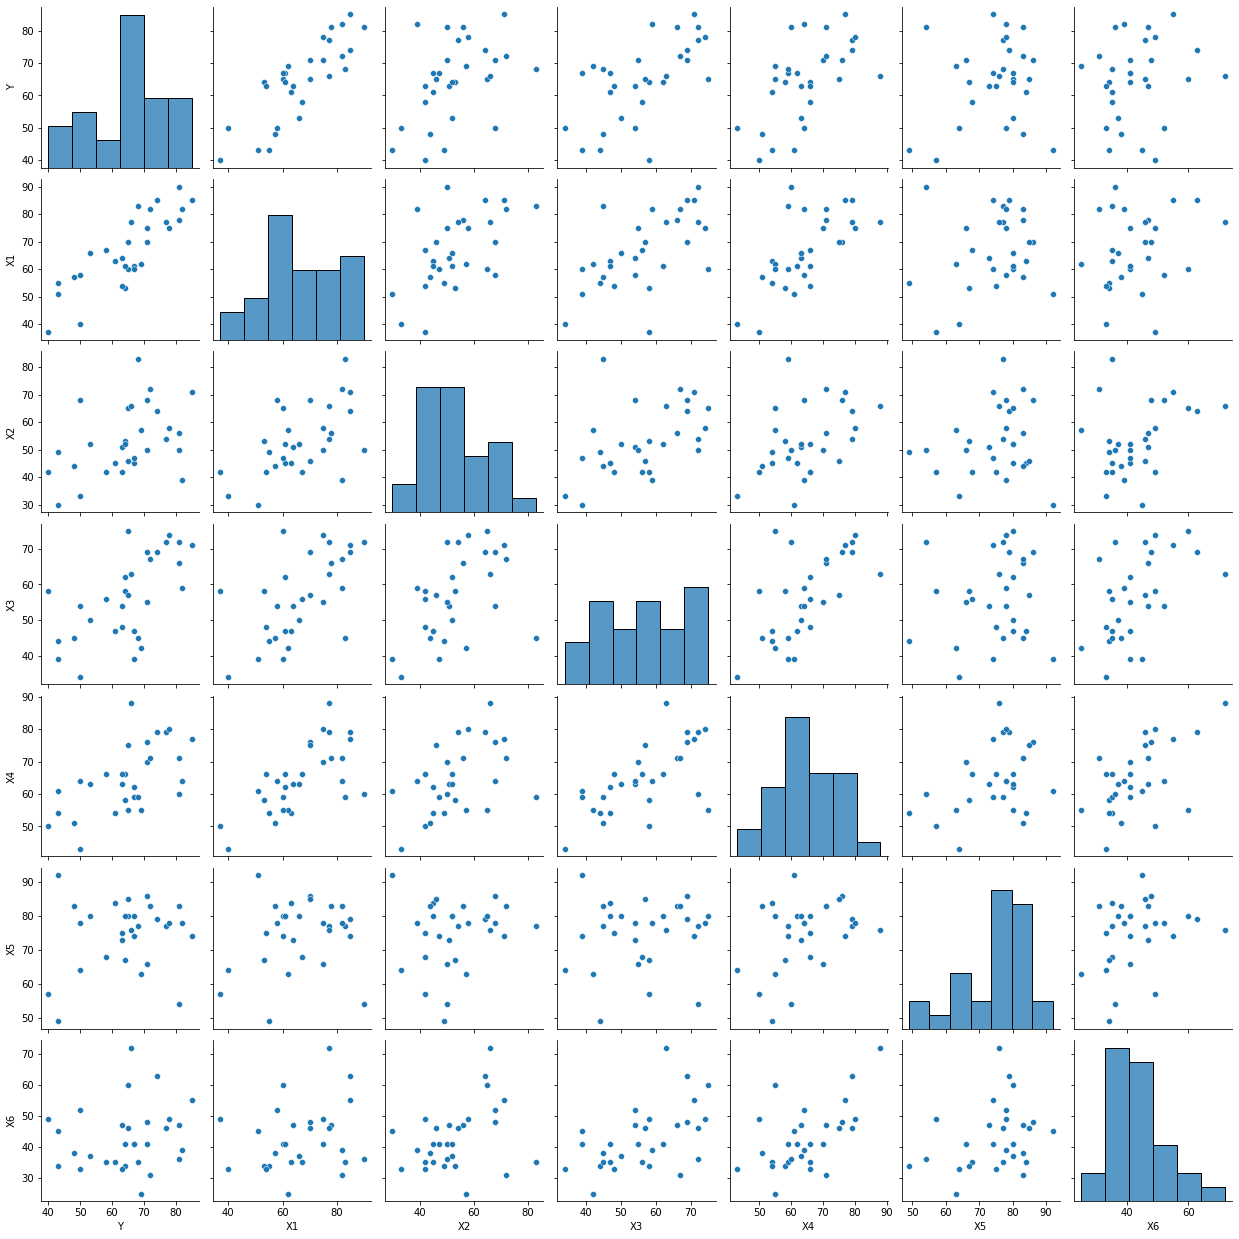

In [6]:
sns.pairplot(df);

## Korelasyon

Korelasyon değerleri değişkenler arasındaki ilişkileri incelememiz için oldukça önemli istatiksel değerlerdir. Peki bu korelasyon değerlerini nasıl yorumlamamız lazım?

![Korelasyon Katsayıları](https://4.bp.blogspot.com/-oizUdNg_XMk/WLAfW-f4ShI/AAAAAAAAEAE/hXpnuCzG-8098Ocsv5Vl-V45GNZ_zOv-QCLcB/s400/correlation_coefficient.gif)

Yukarıdaki şekilde de görüldüğü gibi korelasyon katsayıları **her zaman -1 ile +1 arasında** değerler alır. Ve buradaki işaretin **(+)** veya **(-)** olması sadece bize **ilişkinin yönü hakkında bir bilgi verir, kuvvet açısından herhangi bir bilgi sağlamaz**.

In [7]:
df.corr() # Değişkenler arasındaki korelasyon değerlerini inceleme (Önemli!)

,Y,X1,X2,X3,X4,X5,X6
Y,1.000000,0.825418,0.426117,0.623678,0.590139,0.156439,0.155086
X1,0.825418,1.000000,0.558288,0.596736,0.669197,0.187714,0.224580
X2,0.426117,0.558288,1.000000,0.493331,0.445478,0.147233,0.343293
X3,0.623678,0.596736,0.493331,1.000000,0.640314,0.115965,0.531620
X4,0.590139,0.669197,0.445478,0.640314,1.000000,0.376883,0.574186
X5,0.156439,0.187714,0.147233,0.115965,0.376883,1.000000,0.283343
X6,0.155086,0.224580,0.343293,0.531620,0.574186,0.283343,1.000000


Hesaplanan korelasyon değerleri arasındaki büyüklük küçüklük ilişkisini daha iyi şekilde inceleyebilmek için `heatmap` görselinden yararlanalım.

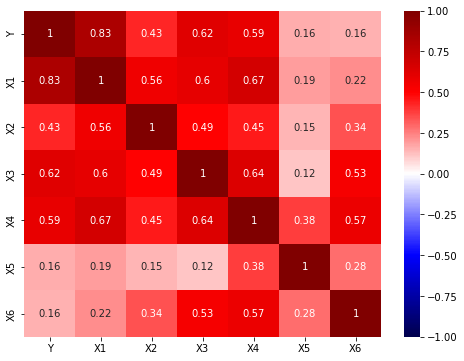

In [8]:
plt.figure(figsize=[8,6])
sns.heatmap(df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

## Multicollinearity

Üstteki korelasyon haritasını incelediğimizde bazı değişkenlerin yüksek derecede ilişkili olduğunu fark ediyoruz. Bu aşamada dikkate almamız gereken 2 tane durum var;
1. Target sütunumuzu (Y) baz aldığımızda özellikle **X1**'in yapacağımız tahmini diğer featurelara kıyasla daha çok etkilediğini görüyoruz. Bu durum kesinlikle istediğimiz bir şey çünkü ne kadar büyük katsayılı değerlerimizin olması, bunların büyük olasılıkla modelimizin bir parçası olarak dahil etmek istediğimiz değişkenler olduğu anlamına gelir. 
2. Ancak tabloya baktığımızda korelasyon değerleri sadece target sütunu bazında hesaplanmamış, featurelar arasında da korelasyon değerleri var ve aralarında **0.67** ve **0.64** gibi güçlü ilişkileri temsil eden korelasyon değerleri var.

> **SORU:** Featurelar arasında görülen bu ilişkileri nasıl yorumlamamız gerek?

Makine öğrenmesi modellerinde genellikle birbiriyle yüksek ilişkili gösteren durumlar sevilir **ama genellikle**! Eğer bulunan bu yüksek ilişkiler featurelar arasında ise bu büyük bir sorun **multicollinearity** olarak adlandırılır. Şimdi bu durumun bizim için neden bir sorun teşkil ettiğini bir örnekle daha iyi kavrayalım.

> **SORU:** Elinizde aşağıdaki tablodaki gibi bir veri seti olsun. Bu veri setini kullanmamızdaki ana amaç aslında listelenen evlere ait fiyat tahmini yapabilmek. Peki sizce bu veri setinde bir multicollinearity sorunu olabilir mi?

![multicollinearity_problem](multicollinearity.png)

## Statsmodels Kullanarak Modelleme

Statsmodels yaklaşımıyla modeller oluşturmanın 2 yolu vardır:

- `statsmodels.api` yöntemini kullanmak
- `statsmodels.formula.api` yöntemini kullanmak

Bu 2 yöntem de temelde aynı işlevi görseler de kullanım açısından birbirlerinden küçük bir farkları var. Şimdi bu farkın ne olduğunu görelim.

### `statsmodels.formula.api`

Bu yöntemde bizim `X` ve `Y` değişkenlerimizi tanımlamamıza gerek yok, bunu zaten kendi içerisinde bizim için yapıyor :)

In [9]:
# Modeli Oluşturma
lm1 = smf.ols('Y ~ X1 + X2 + X3 + X4 + X5 + X6', data=df)

# Modeli Eğitme
fit1 = lm1.fit()

# Oluşturduğumuz modele ilişkin özet tablosunu görüntüleme
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     10.50
Date:                Sun, 09 Apr 2023   Prob (F-statistic):           1.24e-05
Time:                        00:49:57   Log-Likelihood:                -97.250
No. Observations:                  30   AIC:                             208.5
Df Residuals:                      23   BIC:                             218.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.7871     11.589      0.931      0.362     -13.187      34.761
X1             0.6132      0.161      3.809      0.001       0.280       0.946
X2            -0.0731      0.136     -0.538      0.596      -0.354       0.208
X3             0.3203      0.169      1.901      0.070      -0.028       0.669
X4             0.0817      0.221      0.369      0.715      -0.376       0.540
X5             0.0384      0.147      0.261      0.796      -0.266       0.342
X6            -0.2171      0.178     -1.218      0.236      -0.586       0.152
==============================================================================
Omnibus:                        2.386   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.303   Jarque-Bera (JB):                1.255
Skew:                          -0.081   Prob(JB):                        0.534
Kurtosis:                       2.011   Cond. No.                     1.34e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Regresyon İstatistikleri

Bir önceki notebookumuzda bu tabloda karşımıza çıkan değerleri yorumlama kısmını biraz daha detaylandıracağımızı söylemiştik, şimdi sıra geldi karşımıza çıkan bu koca tablodaki değerlerden ne anlamalıyız kısmına :)

### **R<sup>2</sup> (R-squared)**

**R<sup>2</sup>**, regresyon modelimiz tarafından belirlenen featureların, target değişkenimiz olan Y'ye ilişkin gerçekleştirilen tahminlerin doğruluk yüzdesini temsil eder. Yani olabildiğince 1'e yakın R<sup>2</sup> değerleri en çok elde etmek istediğimiz sonuçlardan biridir.

### **Adjusted R<sup>2</sup> (Adj. R-squared)**

İsmen birbirlerine oldukça benzeseler de **Adj. R<sup>2</sup>** değerinin yorumlanması **R<sup>2</sup>**'den biraz daha farklıdır. Adjusted R<sup>2</sup> değeri modelimizde bulunan küçük katsayı değerlerine sahip featureları ve gereksiz featureları bizim için daha iyi bir model oluşturabilmemiz için cezalandırır ve ona göre bir değer hesabı gerçekleştirir. Bu işlem aynı zamanda **overfitting** (ilerleyen derslerde daha detaylı konuşacağız) adını verdiğimiz sorunun da önüne geçmemizde bize katkı sağlar.

### **P-Value (P>|t|)**

**P-Value** bu özet tablosundaki en önemli istatistiklerden biridir. Katsayılarımızın modelimiz aracılığıyla şans eseri ölçülme olasılığının bir ölçüsünü ifade eder. Örneğin, **X5** sütünu için 0.796 olan bir p değeri, **X5** bağımsız değişkeninin, bağımlı değişken olan **Y** üzerinde hiçbir etkisinin olmaması olasılığının %79.6 olduğunu ve buna dair sonuçların bize tesadüfen üretildiğini söyler.

P-Value değeri hakkında daha detaylı bilgi için -----> [P-Value](https://www.youtube.com/watch?v=vemZtEM63GY) (Bu kanaldan her daim yararlanabilirsiniz :))

### **Condition Number (Cond. No.)**

**Condition Number** multicollinearity gibi sayısal problemler hakkında bilgi verir. Düşük condition number değerleri bizim istediğimiz durumları temsil ederken, yüksek condition number değerleri veri setimiz içerisinde bazı sayısal problemler olduğunu söyler.

## Model Geliştirme Süreci

Artık konuştuğumuz bu detaylara göre öğrendiklerimizi verimiz üzerinde uygulayalım.

Değişken seçimizde özellikle bize yardımcı olan bir **P>|t|** değerimiz vardı. Burdan yola çıkarak, çok emin olamadığımız değişkenleri modelimizden kaldıralım ve sonuçları tekrar yorumlayalım.

In [10]:
# X2, X4, X5 sütunları kaldırıldı
lm2 = smf.ols('Y ~ X1 + X3 + X6', data=df)

fit2 = lm2.fit()

fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     22.92
Date:                Sun, 09 Apr 2023   Prob (F-statistic):           1.81e-07
Time:                        00:49:57   Log-Likelihood:                -97.638
No. Observations:                  30   AIC:                             203.3
Df Residuals:                      26   BIC:                             208.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.5777      7.544      1.800      0.084      -1.929      29.084
X1             0.6227      0.118      5.271      0.000       0.380       0.866
X3             0.3124      0.154      2.026      0.053      -0.005       0.629
X6            -0.1870      0.145     -1.291      0.208      -0.485       0.111
==============================================================================
Omnibus:                        2.856   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.240   Jarque-Bera (JB):                1.394
Skew:                          -0.121   Prob(JB):                        0.498
Kurtosis:                       1.972   Cond. No.                         605.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> **SORU:** Yaptığımız bu değişiklikten sonra **R<sup>2</sup>** değerimizde bir küçük bir azalma olmasına rağmen **Adjusted R<sup>2</sup>** değerimizde bir artış yakaladığımızı görüyoruz. Bu durum bizim için ne ifade ediyor?

Bu yaptığımız işlem sonucunda modelimiz biraz daha iyileşmiş gibi duruyor. O zaman modelimizi biraz daha geliştirip geliştirmeyeceğini görmek için **X6**'yı da kaldırmayı deneyelim.

In [11]:
# X6 sütunu kaldırıldı
lm3 = smf.ols('Y ~ X1 + X3', data=df)

fit3 = lm3.fit()

fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     32.74
Date:                Sun, 09 Apr 2023   Prob (F-statistic):           6.06e-08
Time:                        00:49:57   Log-Likelihood:                -98.569
No. Observations:                  30   AIC:                             203.1
Df Residuals:                      27   BIC:                             207.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.8709      7.061      1.398      0.174      -4.618      24.359
X1             0.6435      0.118      5.432      0.000       0.400       0.887
X3             0.2112      0.134      1.571      0.128      -0.065       0.487
==============================================================================
Omnibus:                        6.448   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.040   Jarque-Bera (JB):                1.959
Skew:                          -0.041   Prob(JB):                        0.375
Kurtosis:                       1.751   Cond. No.                         503.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Bu sefer olmadı! Yaptığımız bu işlem her iki **R<sup>2</sup>** değerimizde de düşüşe neden oldu. Biz en iyisi oluşturduğumuz 2. modelle yola devam edelim.

> **NOT:** `Statsmodels`, lineer modeller için yeterli işlevselliğe sahiptir ve istatistiksel özetler için mükemmel bir araçtır. Ancak, `scikit-learn`, veri hazırlamanın yanı sıra lineer olmayan algoritmalar için daha fazla modelleme seçeneğine sahiptir ve her geçen gün büyümektedir. Bu nedenle çoğunlukla bundan sonra `scikit-learn` ile çalışacağız.

## Sklearn Kullanarak Modelleme

Sklearn'ün bazı ek özelliklerine geçmeden önce, sklearn'ün `LinearRegression()` özelliğini kullanarak Simple Survey Dataset örneğimizi tekrarlamaya çalışalım.

Bunun için öncelikle denediğimiz farklı modellerden elde ettiğimiz sonuçların bazılarını sklearn ile tekrardan oluşturalım ve arada bir fark var mı ona bakalım. İşte ilk model:

In [12]:
# Modeli Oluşturma
lr1 = LinearRegression()

# Featureları Oluşturma
X = df.iloc[:, 1:]

# Targetı Oluşturma
y = df.iloc[:, 0]

# Modeli Eğitme
lr1.fit(X, y)

# R2 Değeri
r_squared1 = lr1.score(X,y)
print("R2:", round(r_squared1,3))

# Adjusted R2 Değeri
adjusted_r_squared1 = 1 - (1-r_squared1)*(len(y)-1)/(len(y)-X.shape[1]-1)
print("Adjusted R2:", round(adjusted_r_squared1,3))

R2: 0.733
Adjusted R2: 0.663


Elde ettiğimiz sonucun, yukarıda oluşturduğumuz ilk `statsmodels` modeli için bildirilenle aynı **R<sup>2</sup>** ve **Adjusted R<sup>2</sup>** değerleri olduğunu fark edeceksiniz. 

O zaman, daha önceki en iyi modeli **(X1, X3 ve X6)** hızlıca çalıştıralım ve nasıl performans gösterdiğini görelim.

In [13]:
lr2 = LinearRegression()

X = df[['X1', 'X3', 'X6']]

y = df['Y']

lr2.fit(X, y)

r_squared2 = lr2.score(X, y)
print("R2:", round(r_squared2,3))

adjusted_r_squared2 = 1 - (1-r_squared2)*(len(y)-1)/(len(y)-X.shape[1]-1)
print("Adjusted R2:", round(adjusted_r_squared2,3))

R2: 0.726
Adjusted R2: 0.694


**R<sup>2</sup>** ve **Adjusted R<sup>2</sup>** değerlerinin tekrar aynı olduğuna dikkat edin. Bu durum, yaklaşım tarzları kısmen farklı olsa da her 2 yöntemi de kullanarak aynı sonuçları alacağımızı göstermiş oldu. Artık, `statsmodels` ve `sklearn` ile basit lineer modelleri nasıl yapabileceğimizi gördük.

> **NOT:** Regresyon modellerimizin başarısını incelerken bakabileceğimiz metrikler sadece **R<sup>2</sup>** ve **Adjusted R<sup>2</sup>** ile sınırlı değil! **MSE**, **MAE** gibi farklı metriklerimiz de var. Ama bunları ilerleyen derslerimizde göreceğimiz şimdilik burada kalabiliriz.

Şimdi bir de `sklearn` modelimiz tarafından oluşturulan katsayılara ve sabit değere bakalım.

In [14]:
# lr2 modelinden elde edilen katsayı değerleri
print("Coefficents:", lr2.coef_)

# lr2 modelinden elde edilen sabit değer
print("Intercept:", lr2.intercept_)

Coefficents: [ 0.62272975  0.31238698 -0.18695081]
Intercept: 13.577741068163917


# Gerçek Hayat Örneği: Car Price Predictor Dataset

Şimdiki yapacağımız örnekte araba fiyatı tahmin etmek için [Car Price Predictor Dataset](https://archive.ics.uci.edu/ml/datasets/Automobile)i kullanacağız.

> **NOT:** Veriyle boğuşmaya başlamadan önce [MetaData](https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.names) içerisinden veri hakkında genel bilgi edinmeyi ihmal etmeyin!

## Veriyi Keşfetme

In [15]:
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data', header=None)

columns= ['symboling','normalized-losses','make','fuel-type','aspiration','num-of-doors','body-style','drive-wheels',
          'engine-location','wheel-base','length','width','height','curb-weight','engine-type','num-of-cylinders','engine-size',
          'fuel-system','bore','stroke','compression-ratio','horsepower','peak-rpm','city-mpg', 'highway-mpg','price']
df.columns = columns

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  205 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       205 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

İlk bakışta veri setimiz içerisinde herhangi bir boş değer gözükmüyor. Ancak oldukça fazla sayıda object(str) verimiz var, bu durum bizim hoşumuza giden bir şey değil. Ama object sütunlarına ne yapmamız gerektiğini 2. aşamada konuşacağız.

In [17]:
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


- Bu kısımda, info fonksiyonunu kullanarak göremediğimiz başka sorunlar görüyoruz. Veri setimiz içerisinde **?** ifadeleri var. Yani bu **?**'lerinin, NaN (boş) değerleri temsil ediyor olması lazım. Hadi hemen bu sorunun önüne geçelim.

In [18]:
df.replace('?', np.nan, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  164 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       203 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

Yukarıda elde ettiğimiz çıktıdan, ilk etapta veri setimiz içerisindeki bazı değerlerin bilinmediğini görüyoruz. Şimdilik işleri basit tutmak için, devam edelim ve bilinmeyen değerleri veri setimiz içerisinden kaldıralım.

>**NOT:** Aslında boş değerler barındıran satırları silmek bizim en son uygulamamız gereken yöntemdir. İlerleyen derslerde bu konuya daha detaylı bir şekilde eğiliyo olacağız :)

In [19]:
df.dropna(inplace=True)
len(df)

159

- Tabiki, bu aşamayı bitirmeden önce veri tiplerimizi düzeltmeyi de unutmuyoruz :)

In [20]:
int_columns = ['normalized-losses','horsepower','peak-rpm','price']
float_columns = ['bore','stroke']

for column in int_columns:
    df[column] = df[column].astype(int)
    
for column in float_columns:
    df[column] = df[column].astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159 entries, 3 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          159 non-null    int64  
 1   normalized-losses  159 non-null    int64  
 2   make               159 non-null    object 
 3   fuel-type          159 non-null    object 
 4   aspiration         159 non-null    object 
 5   num-of-doors       159 non-null    object 
 6   body-style         159 non-null    object 
 7   drive-wheels       159 non-null    object 
 8   engine-location    159 non-null    object 
 9   wheel-base         159 non-null    float64
 10  length             159 non-null    float64
 11  width              159 non-null    float64
 12  height             159 non-null    float64
 13  curb-weight        159 non-null    int64  
 14  engine-type        159 non-null    object 
 15  num-of-cylinders   159 non-null    object 
 16  engine-size        159 non

>**SORU:** Ama ben veri setinin içeriğini incelerken gözüme çarpan bir durum daha vardı. Bunu yakalayabildik mi?

In [21]:
df['num-of-doors'] = df['num-of-doors'].apply(lambda x: str(x).replace('four', '4'))
df['num-of-doors'] = df['num-of-doors'].apply(lambda x: str(x).replace('two', '2'))
df['num-of-doors'] = df['num-of-doors'].astype(int)

In [22]:
df['num-of-cylinders'] = df['num-of-cylinders'].apply(lambda x: str(x).replace('two', '2'))
df['num-of-cylinders'] = df['num-of-cylinders'].apply(lambda x: str(x).replace('three', '3'))
df['num-of-cylinders'] = df['num-of-cylinders'].apply(lambda x: str(x).replace('four', '4'))
df['num-of-cylinders'] = df['num-of-cylinders'].apply(lambda x: str(x).replace('five', '5'))
df['num-of-cylinders'] = df['num-of-cylinders'].apply(lambda x: str(x).replace('six', '6'))
df['num-of-cylinders'] = df['num-of-cylinders'].apply(lambda x: str(x).replace('eight', '8'))
df['num-of-cylinders'] = df['num-of-cylinders'].apply(lambda x: str(x).replace('twelve', '12'))
df['num-of-cylinders'] = df['num-of-cylinders'].astype(int)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159 entries, 3 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          159 non-null    int64  
 1   normalized-losses  159 non-null    int64  
 2   make               159 non-null    object 
 3   fuel-type          159 non-null    object 
 4   aspiration         159 non-null    object 
 5   num-of-doors       159 non-null    int64  
 6   body-style         159 non-null    object 
 7   drive-wheels       159 non-null    object 
 8   engine-location    159 non-null    object 
 9   wheel-base         159 non-null    float64
 10  length             159 non-null    float64
 11  width              159 non-null    float64
 12  height             159 non-null    float64
 13  curb-weight        159 non-null    int64  
 14  engine-type        159 non-null    object 
 15  num-of-cylinders   159 non-null    int64  
 16  engine-size        159 non

Veri setimizde bazı `object` veri tipinde olan sütunlar var ve biz bu sütunları makine öğrenmesi modellerimizde **doğrudan input olarak kullanamayız**. Henüz `object` veri tipindeki sütunları kullanarak modeller oluşturmayı öğrenmedik. O yüzden ilk aşamada sadece sayısal sütunlarla ilerleyelim.

In [24]:
subset = ['normalized-losses','num-of-doors','wheel-base','length','width','height',
          'curb-weight','num-of-cylinders','engine-size','bore','stroke','compression-ratio',
          'horsepower','peak-rpm','city-mpg','highway-mpg','price']

cars = df.loc[:,subset]

cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159 entries, 3 to 204
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   normalized-losses  159 non-null    int64  
 1   num-of-doors       159 non-null    int64  
 2   wheel-base         159 non-null    float64
 3   length             159 non-null    float64
 4   width              159 non-null    float64
 5   height             159 non-null    float64
 6   curb-weight        159 non-null    int64  
 7   num-of-cylinders   159 non-null    int64  
 8   engine-size        159 non-null    int64  
 9   bore               159 non-null    float64
 10  stroke             159 non-null    float64
 11  compression-ratio  159 non-null    float64
 12  horsepower         159 non-null    int64  
 13  peak-rpm           159 non-null    int64  
 14  city-mpg           159 non-null    int64  
 15  highway-mpg        159 non-null    int64  
 16  price              159 non

In [25]:
cars.head()

,normalized-losses,num-of-doors,wheel-base,length,width,height,curb-weight,num-of-cylinders,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
3,164,4,99.8,176.6,66.2,54.3,2337,4,109,3.19,3.4,10.0,102,5500,24,30,13950
4,164,4,99.4,176.6,66.4,54.3,2824,5,136,3.19,3.4,8.0,115,5500,18,22,17450
6,158,4,105.8,192.7,71.4,55.7,2844,5,136,3.19,3.4,8.5,110,5500,19,25,17710
8,158,4,105.8,192.7,71.4,55.9,3086,5,131,3.13,3.4,8.3,140,5500,17,20,23875
10,192,2,101.2,176.8,64.8,54.3,2395,4,108,3.50,2.8,8.8,101,5800,23,29,16430


Modellemeye başlamadan önce, özellikle **price** ile ilgili olarak farklı değişkenler arasındaki ilişkiler hakkında bir fikir edinmek için korelasyon değerlerine bakalım.

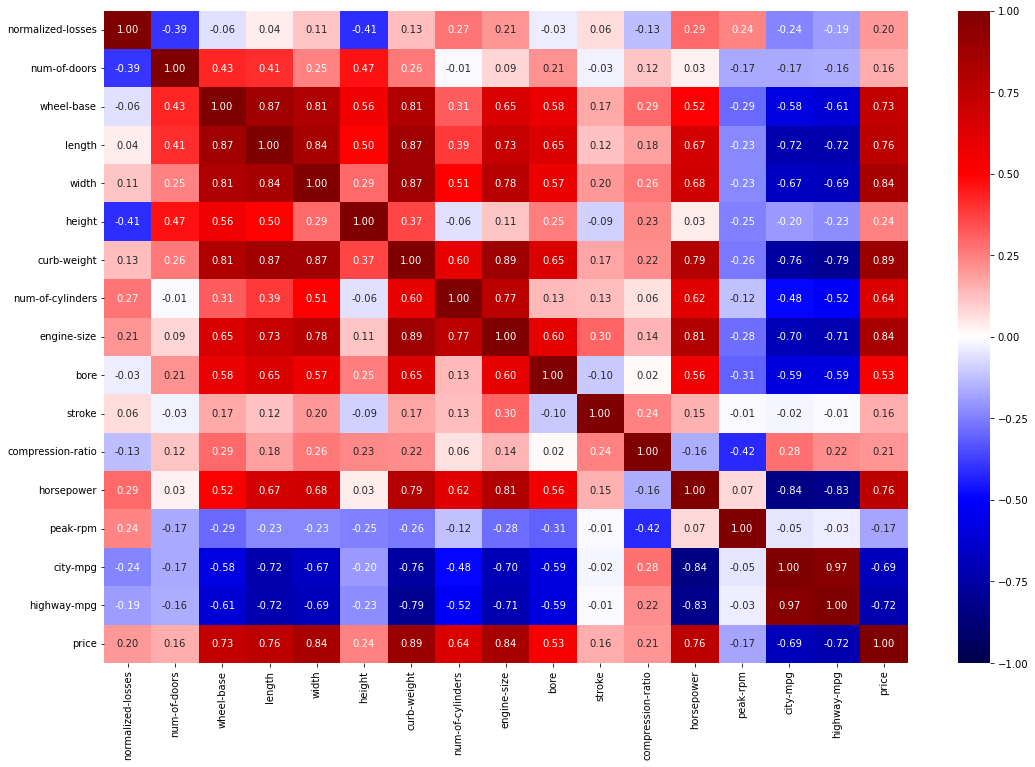

In [26]:
plt.figure(figsize=[18,12])
sns.heatmap(cars.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1, fmt='.2f');

Artık modeliniz için hangi featureların en değerli olabileceğini daha iyi anlamalıyız.

> **SORU:** Korelasyonlar, modelimizde neler olduğuna dair bize **tüm resmi** sağlıyor mu?  
**CEVAP:** Hayır! Bize bir fikir verebilir, ancak korelasyon değerleri **yalnızca yanıt değişkeni** ile ilişkiyi sağlar (diğer tüm faktörler sabit tutulur). **Statsmodels**'dan elde ettiğimiz çıktılar da zaten bu yüzden önemli :)

## Statsmodels Kullanarak Modelleme

Sonunda model oluşturma aşamasına geldik.  İlk modelimizde, gerçekten **price** sütunuyla ilişkili olarak gözüken, korelasyon değeri en az **0.25** olarak hesaplanan featureları modelimize girdi olarak verelim.

In [27]:
cars.rename(columns = {'curb-weight':'curb_weight', 'engine-size':'engine_size', 'wheel-base':'wheel_base', 
                       'num-of-cylinders':'num_of_cylinders', 'city-mpg':'city_mpg', 'highway-mpg':'highway_mpg'},
            inplace=True)

In [28]:
# Modeli Eğitme ve Model Sonucunu Görüntüleme
lsm = smf.ols('price ~ curb_weight + width + engine_size + length + horsepower + wheel_base + num_of_cylinders + bore + city_mpg + highway_mpg', data=cars)
fit1 = lsm.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     80.52
Date:                Sun, 09 Apr 2023   Prob (F-statistic):           1.01e-54
Time:                        00:50:00   Log-Likelihood:                -1457.0
No. Observations:                 159   AIC:                             2936.
Df Residuals:                     148   BIC:                             2970.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -6.835e+04   1.33e+04     -5.146      0.000   -9.46e+04   -4.21e+04
curb_weight          6.4419      1.412      4.563      0.000       3.652       9.232
width              817.1945    221.363      3.692      0.000     379.754    1254.635
engine_size         -4.5511     22.096     -0.206      0.837     -48.215      39.113
length             -87.7771     45.790     -1.917      0.057    -178.263       2.709
horsepower          30.6336     14.551      2.105      0.037       1.878      59.389
wheel_base         173.9359     88.604      1.963      0.052      -1.157     349.029
num_of_cylinders  1322.1048    625.931      2.112      0.036      85.188    2559.021
bore              -257.0786   1219.912     -0.211      0.833   -2667.774    2153.617
city_mpg           -13.0883    148.488     -0.088      0.930    -306.519     280.342
highway_mpg         48.8751    141.204      0.346      0.730    -230.162     327.912
==============================================================================
Omnibus:                       13.571   Durbin-Watson:                   0.804
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.590
Skew:                           0.536   Prob(JB):                     0.000152
Kurtosis:                       4.227   Cond. No.                     1.77e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.77e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- İlk oluşturduğumuz modelimizde **R<sup>2</sup>** ve **Adjusted R<sup>2</sup>** değerlerimiz **0.845** ve **0.834** olarak karşımıza çıktı. İlk adım için hiç de fena bir skor değil.

> **SORU:** Dersin ilk kısmında konuştuğumuz konuları hatırlıyor muyuz? Bu modeli iyileştirmek için ne yapılabilir?

In [29]:
lsm = smf.ols('price ~ curb_weight + width + length + horsepower + wheel_base + num_of_cylinders', data=cars)
fit2 = lsm.fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     137.2
Date:                Sun, 09 Apr 2023   Prob (F-statistic):           9.54e-59
Time:                        00:50:00   Log-Likelihood:                -1457.3
No. Observations:                 159   AIC:                             2929.
Df Residuals:                     152   BIC:                             2950.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -6.621e+04   1.13e+04     -5.840      0.000   -8.86e+04   -4.38e+04
curb_weight          6.0987      1.191      5.119      0.000       3.745       8.452
width              818.2140    217.762      3.757      0.000     387.983    1248.445
length             -90.4939     42.819     -2.113      0.036    -175.092      -5.896
horsepower          25.0045     11.177      2.237      0.027       2.923      47.086
wheel_base         169.7039     86.308      1.966      0.051      -0.814     340.222
num_of_cylinders  1295.4418    394.714      3.282      0.001     515.608    2075.276
==============================================================================
Omnibus:                       12.675   Durbin-Watson:                   0.806
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               15.621
Skew:                           0.527   Prob(JB):                     0.000405
Kurtosis:                       4.116   Cond. No.                     1.52e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- İkinci modelimizde, **P>|t|** değeri büyük olan featureları modelimizden kaldırmak mantıklı bir işlemdi. Demek ki bu featurelara çok da ihtiyacımız yokmuş :) Ve bu işlem sonucunda **R<sup>2</sup>** ve **Adjusted R<sup>2</sup>** değerlerimiz **0.844** ve **0.838** olarak güncellenmiş oldu.

## Dağılımları Anlamak

Regresyon problemlerinde elimizdeki değişkenlerin nasıl bir dağılım gösterdiği oldukça önemli bir parametredir. Eğer çarpık dağılımlara sahipsek, bu durum **modelin öğrenmesini zorlaştıran** bir etmen olacaktır. Peki neden? Gelin örnek bir senaryo üzerinden konuşalım.

![Normal_Data](https://data.library.virginia.edu/files/hist_og.png)

Yukarıdaki histograma baktığımızda alana ilişkin dağılımı görüyoruz ve oldukça çarpık bir dağılım bizi karşılıyor. Elimizdeki alan bilgileri genellikle **0-100.000** arasında olmasına rağmen, elimizde az sayıda **+100.000** alana sahip değerler de var. İşte bu öğrenmeyi oldukça zorlaştıran bir etmen! Peki ne yapmalıyız?

![Log_Transformation](https://data.library.virginia.edu/files/hist_log.png)


Eğer bu alan dağılımımıza **logaritmik dönüşüm** uygularsak, dağılımın oldukça normale yakınsayacağını göreceksiniz. Artık işler daha kolay :)

Şimdi biz de bu konuştuklarımızı target sütunumuz olan **price** sütunu için uygulayalım ve model performansındaki etkisini inceleyelim.

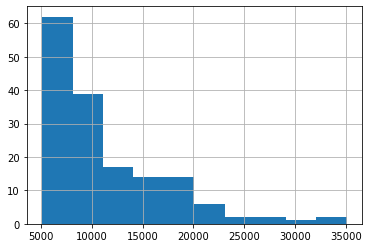

In [30]:
cars.price.hist();

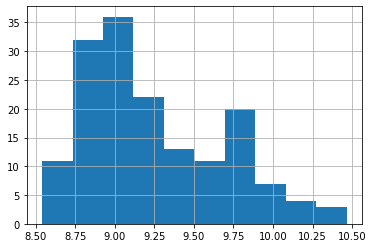

In [31]:
cars['log_price'] = np.log(cars.price)

# Artık dağılım daha iyi gözüküyor :)
cars.log_price.hist();

Peki yaptığımız bu işlemin modelimizin başarısına gerçekten bir etkisi oldu mu? Hemen bakalım :)

In [32]:
# Modelimizi tekrar eğitelim
lsm = smf.ols('log_price ~ curb_weight + width + length + horsepower + wheel_base + num_of_cylinders', data = cars)
fit3 = lsm.fit()
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     182.5
Date:                Sun, 09 Apr 2023   Prob (F-statistic):           7.82e-67
Time:                        00:50:00   Log-Likelihood:                 71.905
No. Observations:                 159   AIC:                            -129.8
Df Residuals:                     152   BIC:                            -108.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            4.1188      0.754      5.459      0.000       2.628       5.609
curb_weight          0.0004   7.93e-05      4.837      0.000       0.000       0.001
width                0.0381      0.014      2.630      0.009       0.009       0.067
length               0.0024      0.003      0.848      0.398      -0.003       0.008
horsepower           0.0035      0.001      4.731      0.000       0.002       0.005
wheel_base           0.0079      0.006      1.380      0.170      -0.003       0.019
num_of_cylinders     0.0340      0.026      1.294      0.198      -0.018       0.086
==============================================================================
Omnibus:                       17.706   Durbin-Watson:                   1.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.656
Skew:                           0.688   Prob(JB):                     1.20e-05
Kurtosis:                       4.235   Cond. No.                     1.52e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Hem **R<sup>2</sup>** değerinde hem de **Adjusted R<sup>2</sup>** değerinde azımsanamayacak bir başarı artışı yaşadık. Bu gerçekten de işe yarayan bir yöntemmiş :)

Peki, modelimizin ulaşabileceği maksimum başarı bu mu? Hayır! Daha `object` tipindeki verilerimizi modelimize dahil etmedik.

## Feature Encoding

Biz oluşturduğumuz modeli kullanarak bir arabanın fiyatını tahmin etmeye çalışıyoruz ve şu ana kadar geliştirdiğimiz modelde ciddi bir başarıya da sahibiz ama neden daha başarılı bir model oluşturamayalım? 

> **SORU:** Şu ana kadar modelimize dahil ettiğimiz featureları düşünün. Sanki oldukça önemli olabilecek bir featureı atladık gibi geliyor?

### One Hot Encoding vs Label Encoding

<center>
<img src="https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F4795937%2F06e3ce1d260ed87abc4678d04f998a75%2FJune-3_ML-infograph-for-blog-1.png?generation=1601378568972200&alt=media" />
</center>

In [33]:
df.make.value_counts()

toyota           31
nissan           18
honda            13
subaru           12
mazda            11
volvo            11
mitsubishi       10
dodge             8
volkswagen        8
peugot            7
plymouth          6
saab              6
mercedes-benz     5
bmw               4
audi              4
chevrolet         3
jaguar            1
porsche           1
Name: make, dtype: int64

In [34]:
brand = pd.get_dummies(df.make, drop_first=True)
brand

,bmw,chevrolet,dodge,honda,jaguar,mazda,mercedes-benz,mitsubishi,nissan,peugot,plymouth,porsche,saab,subaru,toyota,volkswagen,volvo
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
201,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
202,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
203,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [35]:
# Oluşturduğumuz brand değişkeniyle dataframemizi birleştirelim
cars2 = cars.join(brand)

In [36]:
cars2.head()

,normalized-losses,num-of-doors,wheel_base,length,width,height,curb_weight,num_of_cylinders,engine_size,bore,...,mitsubishi,nissan,peugot,plymouth,porsche,saab,subaru,toyota,volkswagen,volvo
3,164,4,99.8,176.6,66.2,54.3,2337,4,109,3.19,...,0,0,0,0,0,0,0,0,0,0
4,164,4,99.4,176.6,66.4,54.3,2824,5,136,3.19,...,0,0,0,0,0,0,0,0,0,0
6,158,4,105.8,192.7,71.4,55.7,2844,5,136,3.19,...,0,0,0,0,0,0,0,0,0,0
8,158,4,105.8,192.7,71.4,55.9,3086,5,131,3.13,...,0,0,0,0,0,0,0,0,0,0
10,192,2,101.2,176.8,64.8,54.3,2395,4,108,3.50,...,0,0,0,0,0,0,0,0,0,0


- Artık araba markasının fiyat tahmini modelimize nasıl bir etki yaptığını görebiliriz.

In [37]:
import statsmodels.api as sm

y = cars2.log_price
x = cars2.drop(columns=['price','log_price','height','compression-ratio','normalized-losses','num-of-doors','stroke','peak-rpm'])

lsm = sm.OLS(y,x)
fit4 = lsm.fit()
fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              log_price   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.894e+04
Date:                Sun, 09 Apr 2023   Prob (F-statistic):                   1.13e-235
Time:                        00:50:00   Log-Likelihood:                          111.24
No. Observations:                 159   AIC:                                     -168.5
Df Residuals:                     132   BIC:                                     -85.61
Df Model:                          27                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
wheel_base           0.0028      0.006      0.445      0.657      -0.010       0.015
length           -3.938e-05      0.003     -0.012      0.991      -0.007       0.007
width                0.1063      0.012      9.128      0.000       0.083       0.129
curb_weight          0.0005   9.46e-05      4.839      0.000       0.000       0.001
num_of_cylinders     0.0877      0.044      1.981      0.050       0.000       0.175
engine_size         -0.0055      0.002     -3.539      0.001      -0.009      -0.002
bore                 0.2333      0.112      2.082      0.039       0.012       0.455
horsepower           0.0031      0.001      3.196      0.002       0.001       0.005
city_mpg            -0.0095      0.010     -0.988      0.325      -0.028       0.010
highway_mpg          0.0111      0.009      1.241      0.217      -0.007       0.029
bmw                  0.5578      0.113      4.938      0.000       0.334       0.781
chevrolet            0.0949      0.123      0.772      0.441      -0.148       0.338
dodge               -0.0267      0.088     -0.304      0.761      -0.201       0.147
honda                0.0546      0.082      0.666      0.506      -0.107       0.217
jaguar               0.2365      0.183      1.295      0.198      -0.125       0.598
mazda               -0.0480      0.084     -0.572      0.568      -0.214       0.118
mercedes-benz        0.0949      0.113      0.843      0.401      -0.128       0.318
mitsubishi          -0.1382      0.083     -1.666      0.098      -0.302       0.026
nissan              -0.0021      0.083     -0.025      0.980      -0.167       0.163
peugot              -0.2040      0.102     -2.007      0.047      -0.405      -0.003
plymouth            -0.0430      0.091     -0.473      0.637      -0.223       0.137
porsche              0.2032      0.168      1.208      0.229      -0.129       0.536
saab                 0.0408      0.094      0.435      0.665      -0.145       0.227
subaru              -0.1675      0.104     -1.604      0.111      -0.374       0.039
toyota              -0.0284      0.079     -0.359      0.720      -0.185       0.128
volkswagen          -0.0423      0.087     -0.485      0.628      -0.215       0.130
volvo               -0.0615      0.094     -0.654      0.514      -0.247       0.125
==============================================================================
Omnibus:                        5.952   Durbin-Watson:                   1.735
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                5.517
Skew:                           0.413   Prob(JB):                       0.0634
Kurtosis:                       3.387   Cond. No.                     7.69e+04
=======================================

In [38]:
y = cars2.log_price
x = cars2.drop(columns=['price','log_price','height','compression-ratio','normalized-losses','num-of-doors','stroke','peak-rpm'])
x = sm.add_constant(x)

lsm = sm.OLS(y,x)
fit4 = lsm.fit()
fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     78.90
Date:                Sun, 09 Apr 2023   Prob (F-statistic):           4.45e-68
Time:                        00:50:00   Log-Likelihood:                 131.02
No. Observations:                 159   AIC:                            -206.0
Df Residuals:                     131   BIC:                            -120.1
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.8236      0.957      6.085      0.000       3.930       7.717
wheel_base           0.0023      0.006      0.413      0.680      -0.009       0.013
length               0.0004      0.003      0.128      0.899      -0.005       0.006
width                0.0335      0.016      2.121      0.036       0.002       0.065
curb_weight          0.0005   8.39e-05      5.508      0.000       0.000       0.001
num_of_cylinders    -0.0122      0.043     -0.287      0.775      -0.096       0.072
engine_size         -0.0005      0.002     -0.323      0.748      -0.004       0.003
bore                -0.0576      0.110     -0.522      0.602      -0.276       0.160
horsepower           0.0033      0.001      3.884      0.000       0.002       0.005
city_mpg            -0.0101      0.009     -1.188      0.237      -0.027       0.007
highway_mpg          0.0078      0.008      0.986      0.326      -0.008       0.024
bmw                  0.3137      0.108      2.909      0.004       0.100       0.527
chevrolet           -0.2039      0.119     -1.707      0.090      -0.440       0.032
dodge               -0.3038      0.090     -3.365      0.001      -0.482      -0.125
honda               -0.2089      0.085     -2.471      0.015      -0.376      -0.042
jaguar              -0.1573      0.174     -0.902      0.369      -0.502       0.188
mazda               -0.2273      0.080     -2.839      0.005      -0.386      -0.069
mercedes-benz        0.0673      0.100      0.674      0.502      -0.130       0.265
mitsubishi          -0.3767      0.083     -4.520      0.000      -0.542      -0.212
nissan              -0.2420      0.084     -2.890      0.005      -0.408      -0.076
peugot              -0.2361      0.090     -2.616      0.010      -0.415      -0.058
plymouth            -0.3258      0.093     -3.499      0.001      -0.510      -0.142
porsche              0.1800      0.149      1.207      0.230      -0.115       0.475
saab                -0.1289      0.088     -1.468      0.145      -0.303       0.045
subaru              -0.2771      0.094     -2.938      0.004      -0.464      -0.090
toyota              -0.2546      0.079     -3.204      0.002      -0.412      -0.097
volkswagen          -0.2322      0.083     -2.786      0.006      -0.397      -0.067
volvo               -0.1126      0.084     -1.345      0.181      -0.278       0.053
==============================================================================
Omnibus:                        3.079   Durbin-Watson:                   1.551
Prob(Omnibus):                  0.214   Jarque-Bera (JB):                3.142
Skew:                           0.107   Prob(JB):                        0.208
Kurtosis:                       3.654   Cond. No.                     2.64e+05
=====================================================

- Hem **R<sup>2</sup>** değerinde hem de **Adjusted R<sup>2</sup>** değerinde oldukça yüksek bir skor artışı daha yakaladık. Demek ki gerçekten de arabanın markası fiyatını tahmin etmekte oldukça etkili bir featuremış :)

## Sizin Sıranız

Derste öğrendiğimiz yöntemleri uygulayarak oluşturduğumuz bu modelin skorunu daha da arttırmak artık size kalmış :)